In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import groupby
import numpy as np
import re
import os

In [2]:
class Experiment:
    @staticmethod
    def _preprocess_csv(df):
        # Synchronicity problems cause some experiment
        # runs have periods that don't start at 0. So
        # the periods interval must be shifted so that
        # all experiment runs start at 0.
        df.index = df.index.map(lambda t: t - np.min(df.index))

        # Columns that are not relative to the CPU usage
        # of the device must be removed from the calculation
        # of the total CPU usage for each time step
        cols_drop = ['Stack', 'Mbps'] + (['main'] if 'main' in df.columns else [])
        total_cpu_usage = np.sum(df.drop(cols_drop, axis=1), axis=1)

        df['CPU'] = df['wifi'].values / total_cpu_usage 
        return df[['CPU', 'Stack', 'Mbps']]

    def __init__(self, name: str, directory: str, reps_file_names: str):
        self.name = name
        reps = ([pd.read_csv(f'{directory}/{file_name}', index_col='period') for file_name in reps_file_names])
        self.repetitions = [Experiment._preprocess_csv(rep) for rep in reps]

    def get_time_series(self, metric: str) -> np.array:
        return np.stack([rep[metric].values[:176] for rep in self.repetitions], axis=1)

In [42]:
class ExperimentsSuite:
    def __init__(self, data_dir: str):
        runs = os.listdir('./formated_data')
        exps_file_names = {exp_name: list(group) for exp_name, group in groupby(runs, key=lambda r: r[:-6])}
        self.experiments = {name: Experiment(name, data_dir, exps_file_names[name]) for name in exps_file_names}

    @staticmethod
    def _group_models(experiments):
        groups = {key: [] for key in set([experiment[2:] for experiment in experiments])} 
        for experiment in experiments:
            groups[experiment[2:]].append(experiment)
        return groups

    def plot_experiments(self, metric):
        colors = ['indianred', 'limegreen', 'royalblue']
        x_ticks = np.arange(0, 175, 25)
        groupped_models = ExperimentsSuite._group_models(self.experiments.keys())

        subplots = [plt.subplots(1, 1, figsize=(16, 9)) for _ in groupped_models]
        figs, axis = list(zip(*subplots))
        for ax, group in zip(axis, groupped_models):
            for i, experiment in enumerate(groupped_models[group]):
                series = self.experiments[experiment].get_time_series(metric)
                median, q1, q3 = np.percentile(series, [50, 25, 75], axis=1)
                t = np.arange(series.shape[0])
                ax.plot(t, median, color=colors[i], label=experiment[:2])
                ax.fill_between(t, q1, q3, alpha=0.1, color=colors[i], linewidth=None)
            ax.set_xlabel('Time (s)', fontsize=20)
            ax.set_ylabel(metric, fontsize=20, labelpad=10.0)
            ax.set_xticks(x_ticks)
            ax.set_title(group, fontsize=30, pad=30.0)
            ax.legend(ncol=len(groupped_models), loc='upper center', borderaxespad=-2, frameon=False)
            ax.grid(color='gainsboro', linestyle=':', linewidth=2)
            ax.set_xlim(left=0, right=175)
        return {name: fig for name, fig in zip(groupped_models, figs)}
    
    def get_factors_importance(self):
        levels = ['A2I1M0', 'A2I1M3', 'A2I2M0', 'A2I2M3', 'A3I1M0', 'A3I1M3', 'A3I2M0', 'A3I2M3']
        encoded_A_levels = np.array([-1, -1, -1, -1, 1, 1, 1, 1])
        encoded_I_levels = np.array([-1, -1, 1, 1, -1, -1, 1, 1])
        encoded_M_levels = np.array([1, -1, 1, -1, 1, -1, 1, -1])
        first_column = np.ones_like(encoded_I_levels)
        second_column = encoded_A_levels
        third_column = encoded_I_levels
        fourth_column = encoded_M_levels
        fith_column = encoded_A_levels * encoded_I_levels
        sixth_column = encoded_A_levels * encoded_M_levels
        seventh_column = encoded_I_levels * encoded_M_levels
        eigth_column = encoded_A_levels * encoded_I_levels * encoded_M_levels
        X = np.stack([first_column, second_column, third_column, fourth_column, fith_column, sixth_column, seventh_column, eigth_column], axis=1)
        
        cpu_series = np.array([self.experiments[level].get_time_series('CPU') for level in levels])
        cpu_vals = np.mean(cpu_series[:,150:,:], axis=1)
        mean_cpus = np.mean(cpu_vals, axis=-1)
        system_solutions = np.linalg.solve(X, mean_cpus)
        errors = cpu_vals - np.expand_dims(mean_cpus, axis=-1)
        squared_errors = np.square(errors)
        squared_system_solutions = np.square(system_solutions)
        squared_cpus = np.square(cpu_vals)
        SSY = np.sum(squared_cpus)
        SSE = np.sum(squared_errors)
        SSqs = 8 * 10 * squared_system_solutions
        SST = SSY - SSqs[0]
        
        importances = (np.concatenate([SSqs[1:], np.expand_dims(SSE, axis=0)]) / np.expand_dims(SST, axis=0)).T
        return pd.DataFrame(data=np.expand_dims(np.round_(importances, 2), axis=0), columns=['A', 'I', 'M', 'AI', 'AM', 'IM', 'AIM', 'Err'])

In [43]:
experiments_suite = ExperimentsSuite('./formated_data')

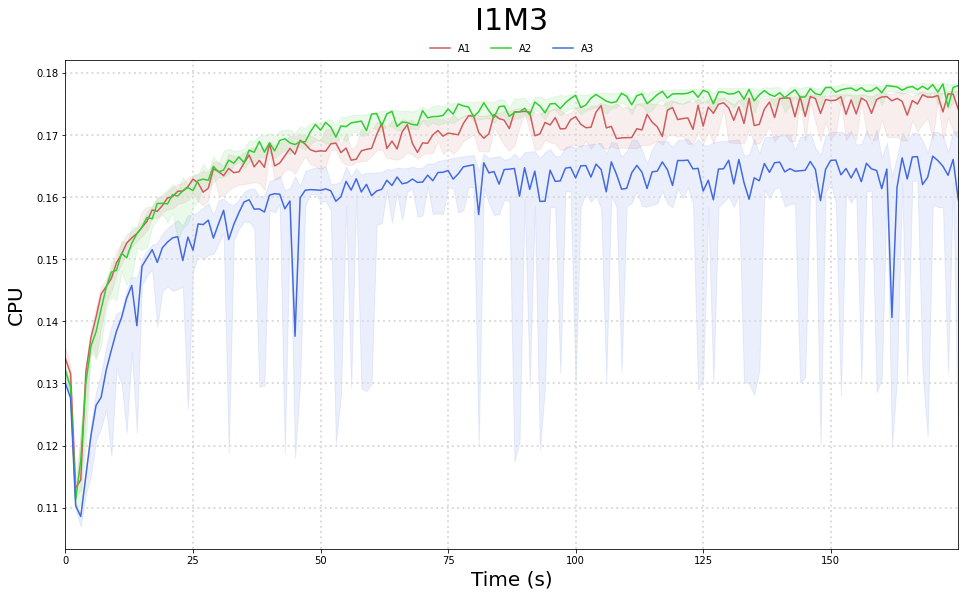

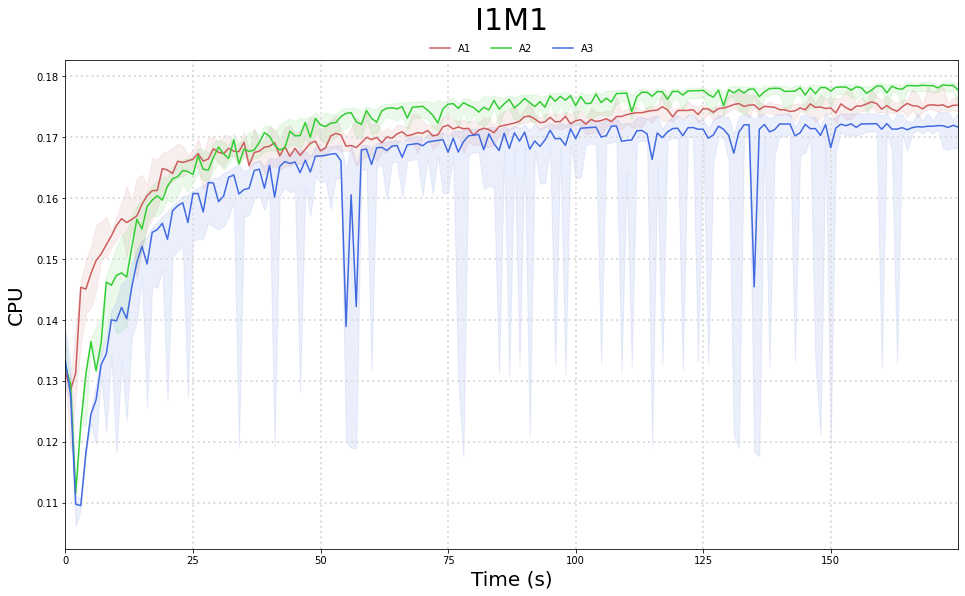

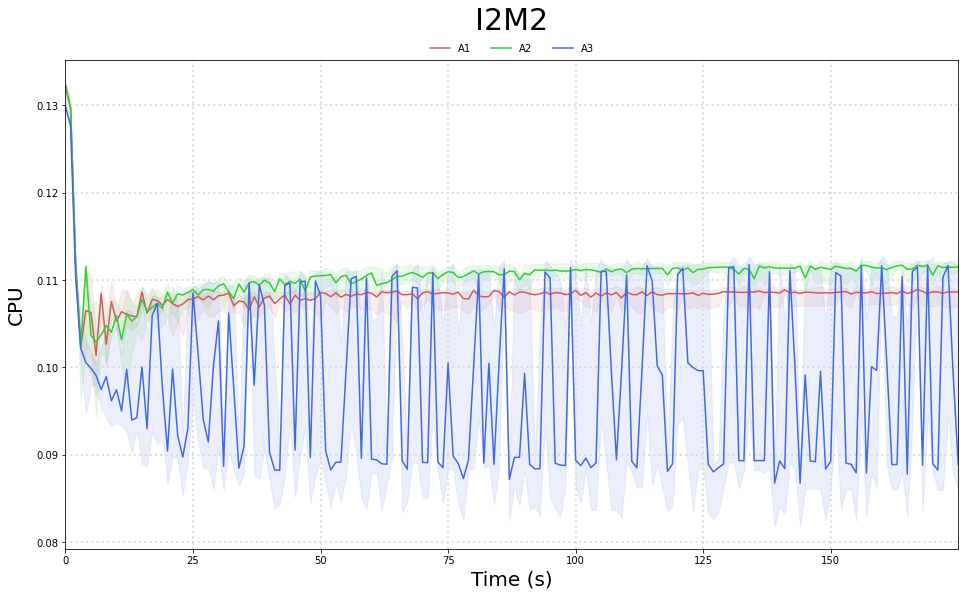

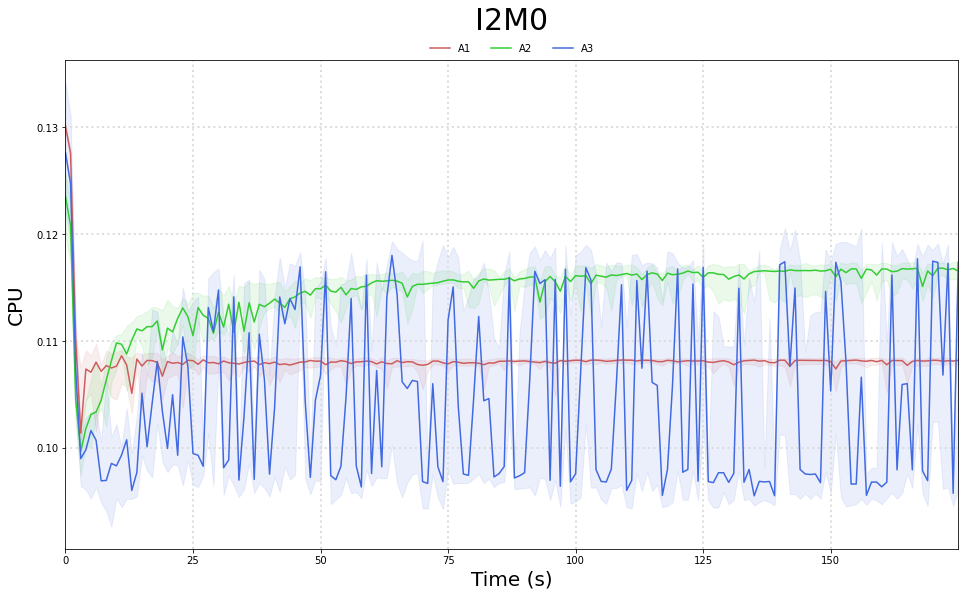

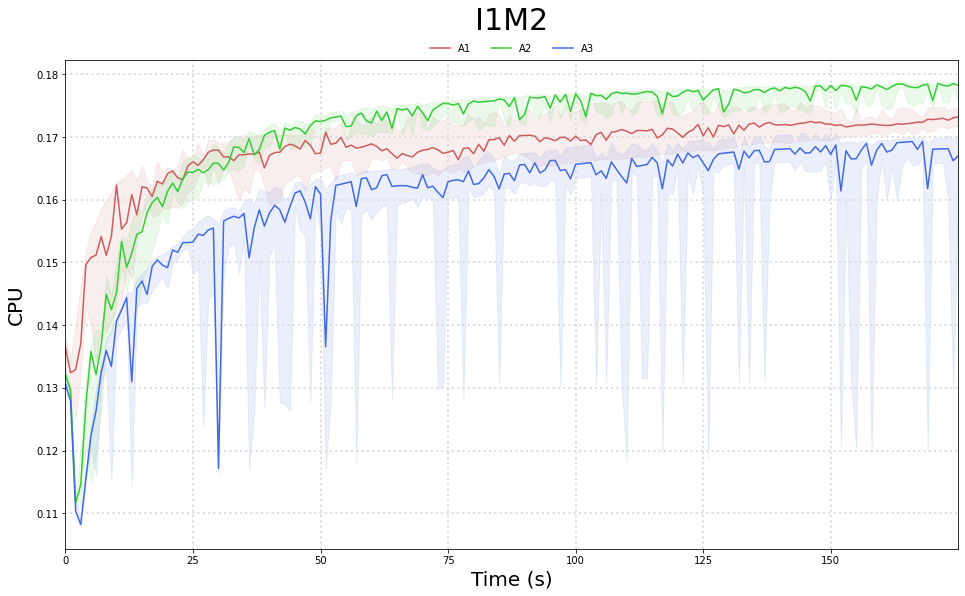

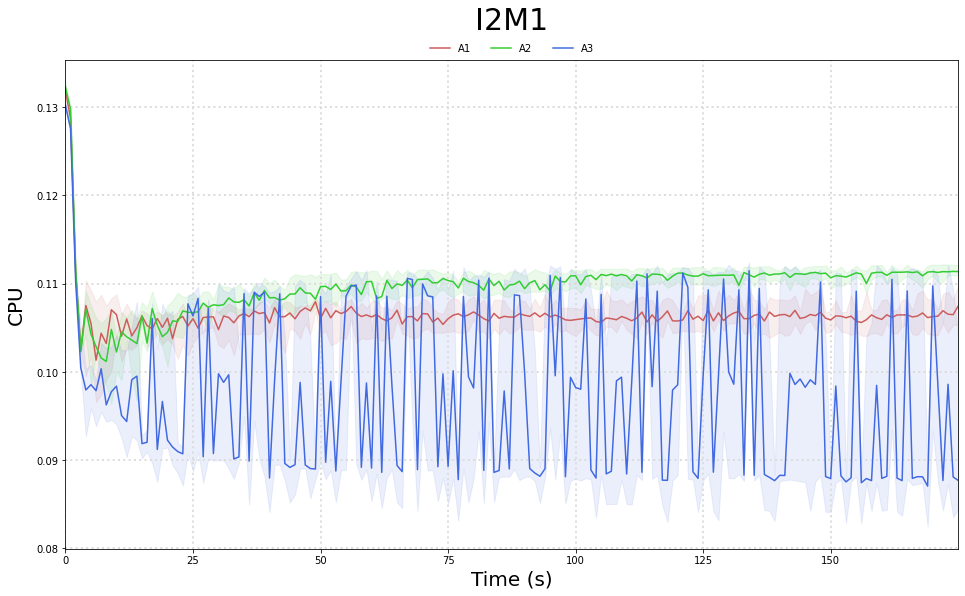

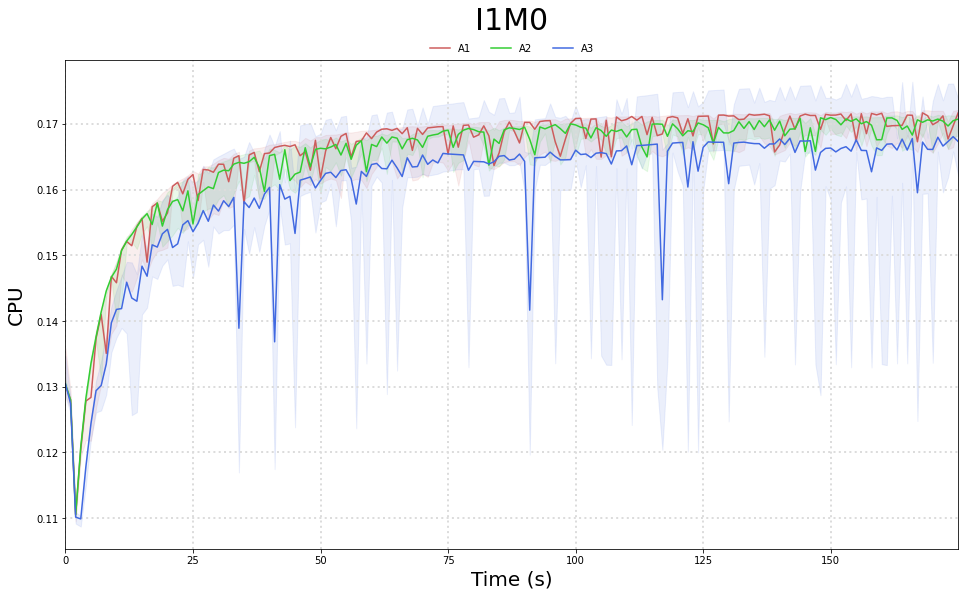

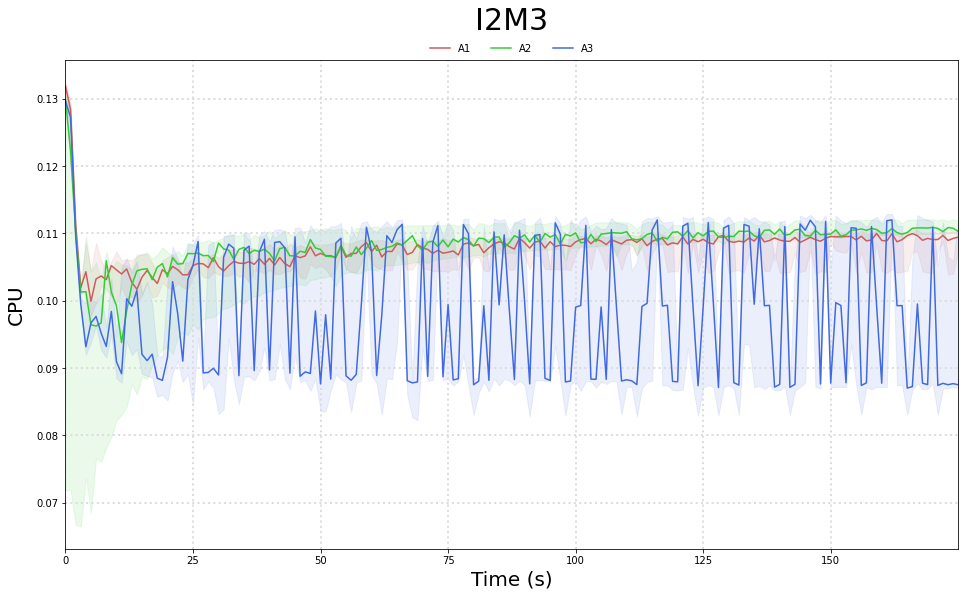

In [5]:
figs = experiments_suite.plot_experiments('CPU')
for fig in figs:
    figs[fig].savefig(f'./graphs/{fig}_wifi.pdf')

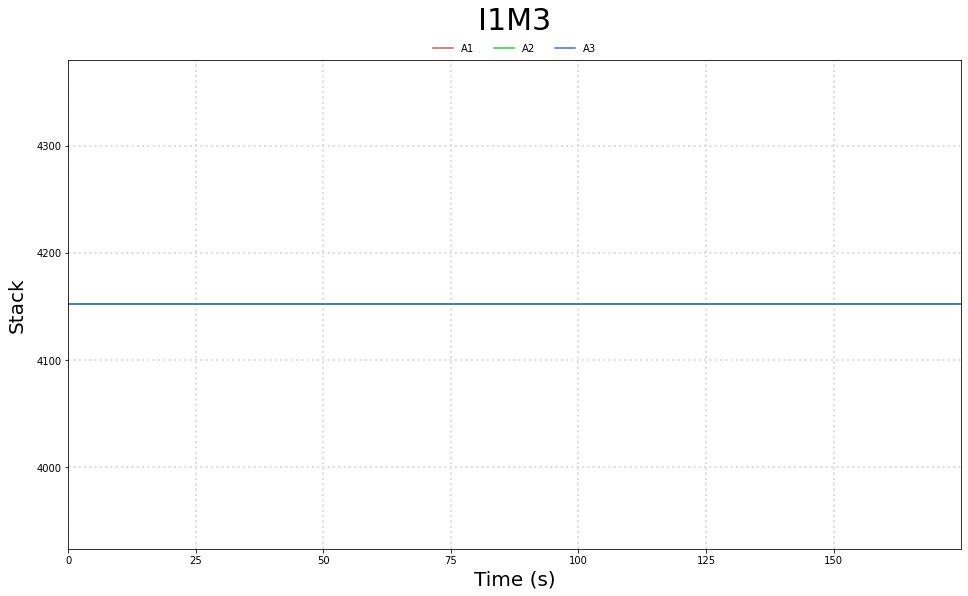

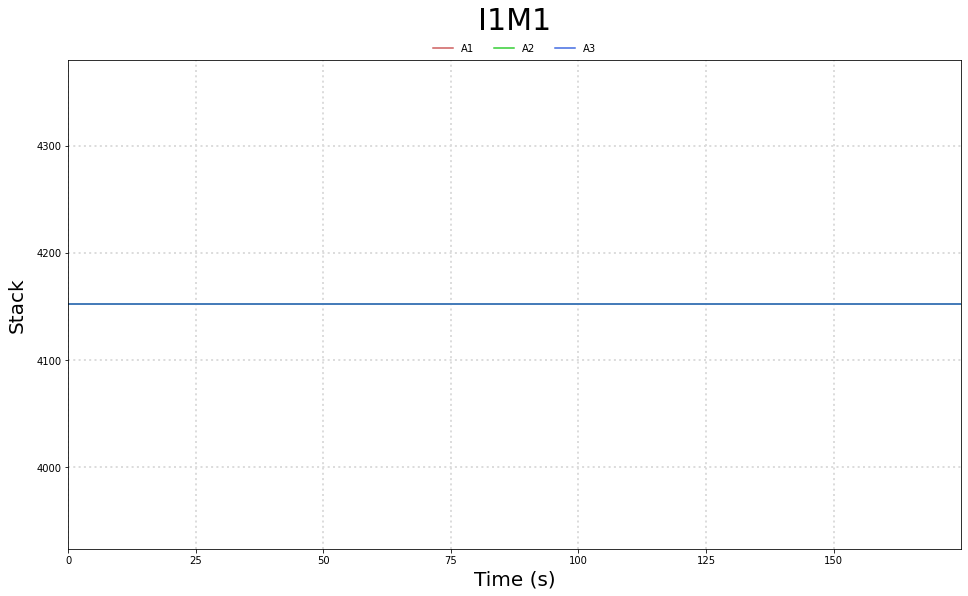

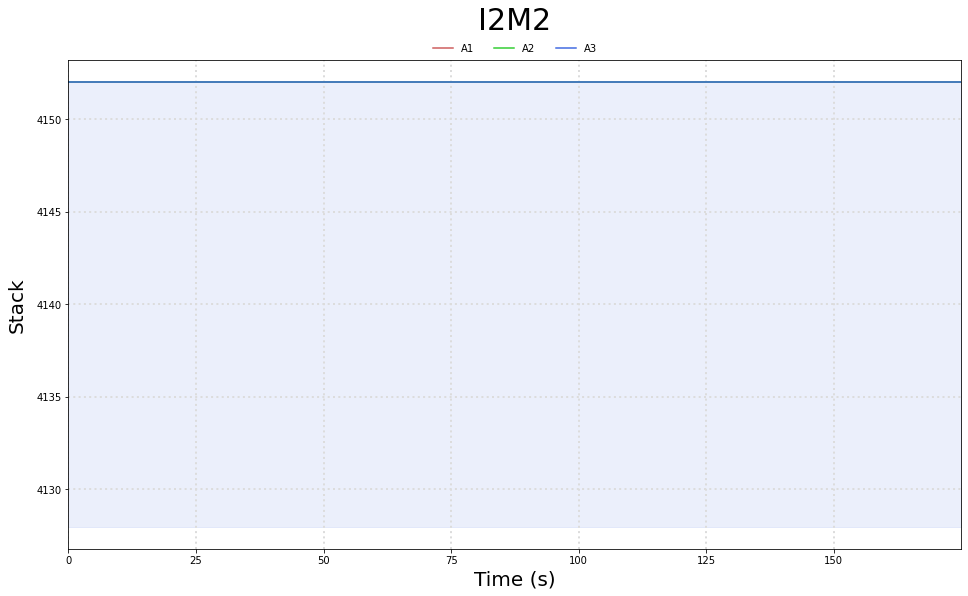

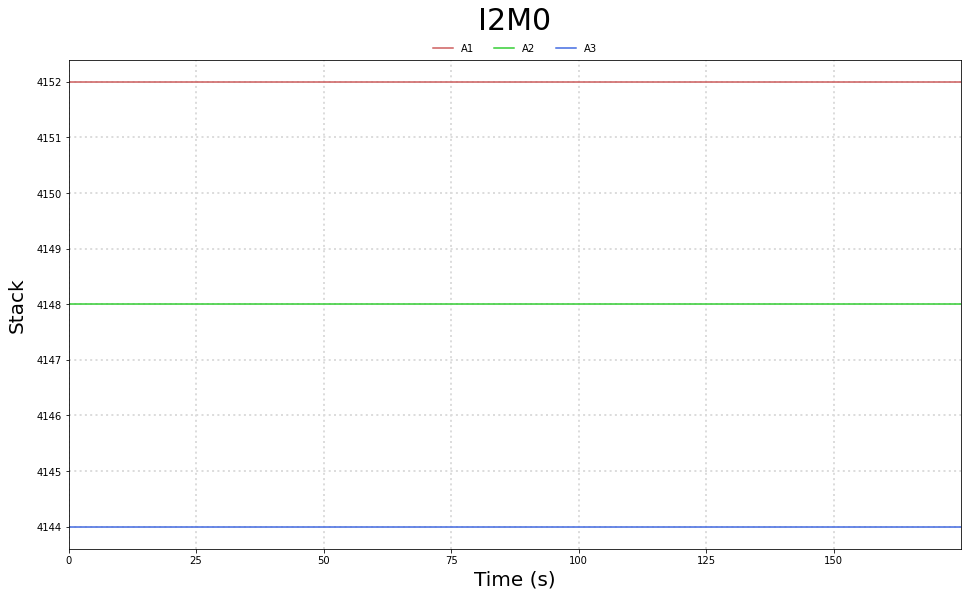

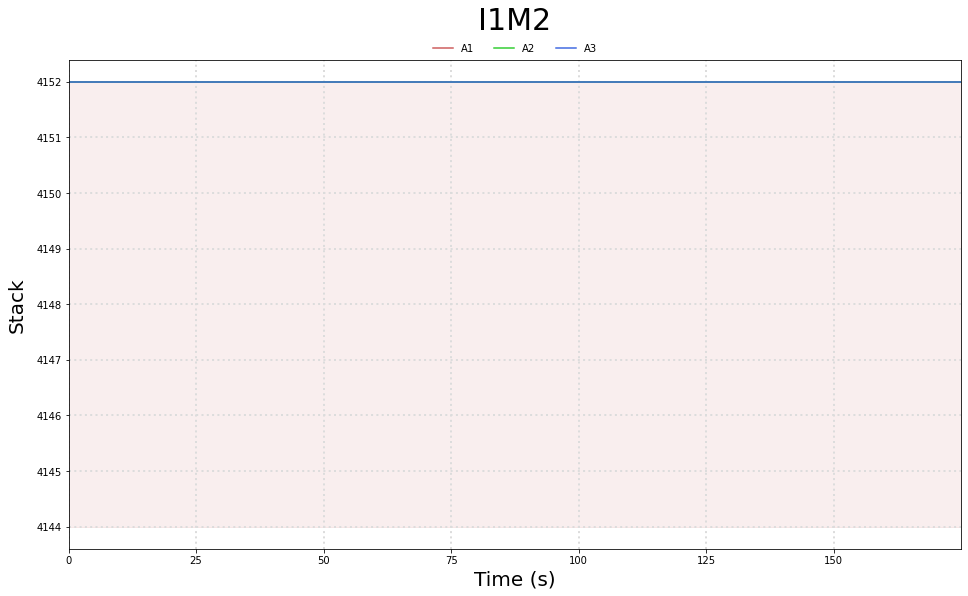

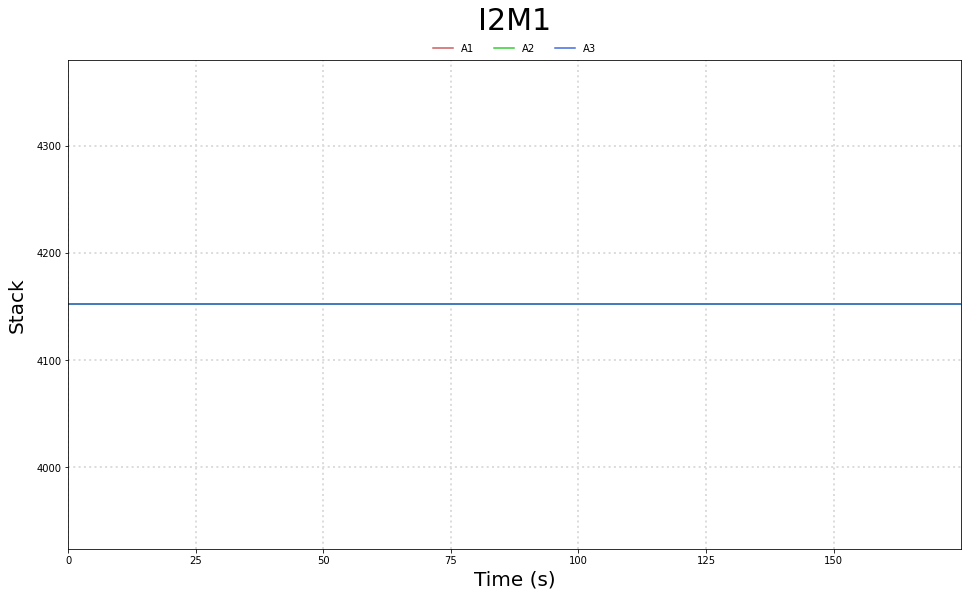

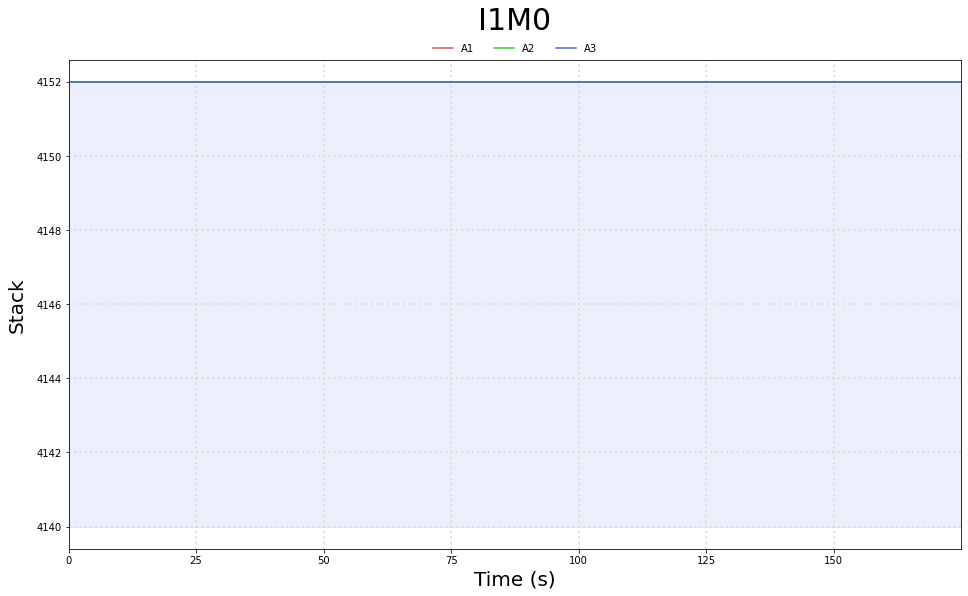

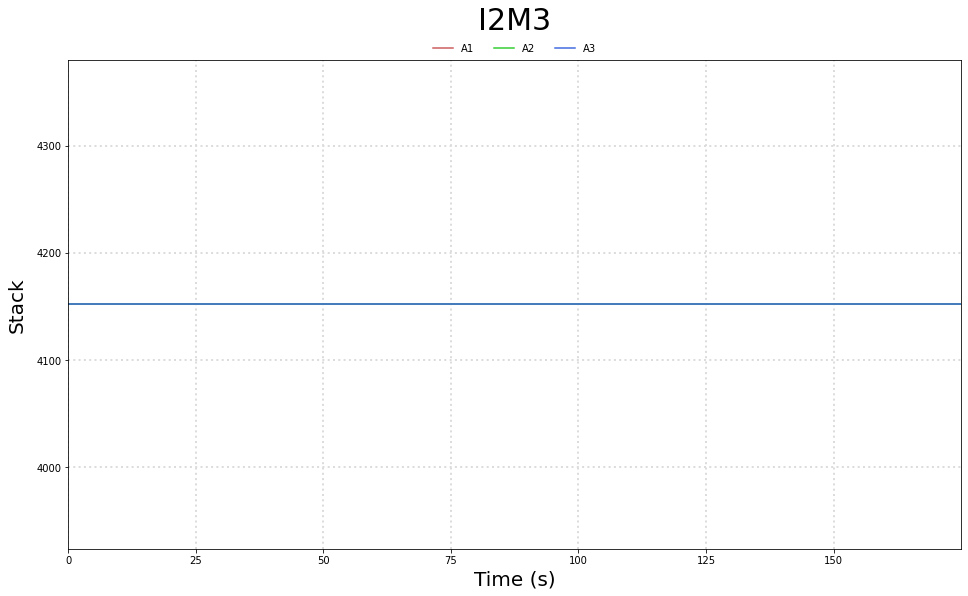

In [6]:
figs = experiments_suite.plot_experiments('Stack')
for fig in figs:
    figs[fig].savefig(f'./graphs/{fig}_Stack.pdf')

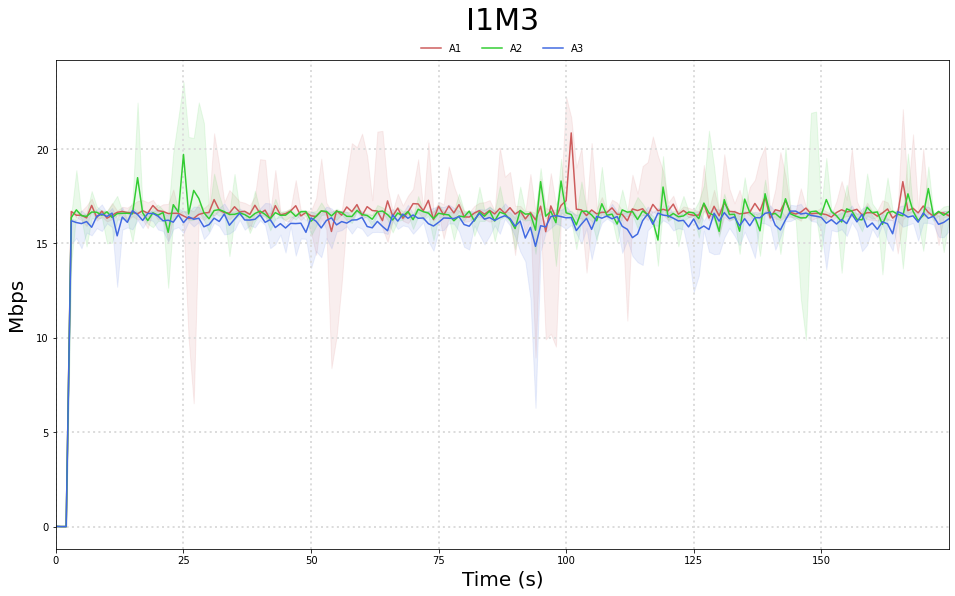

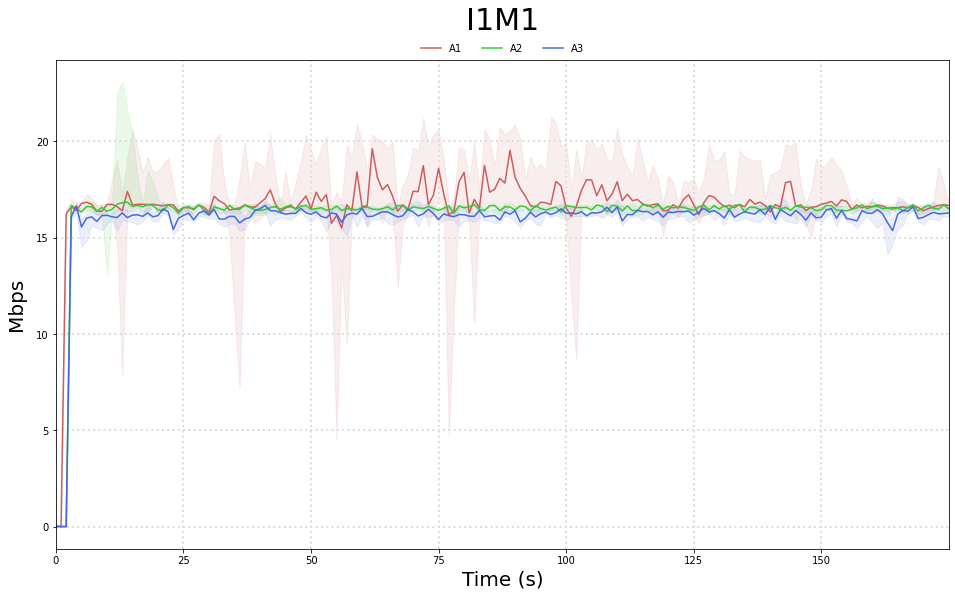

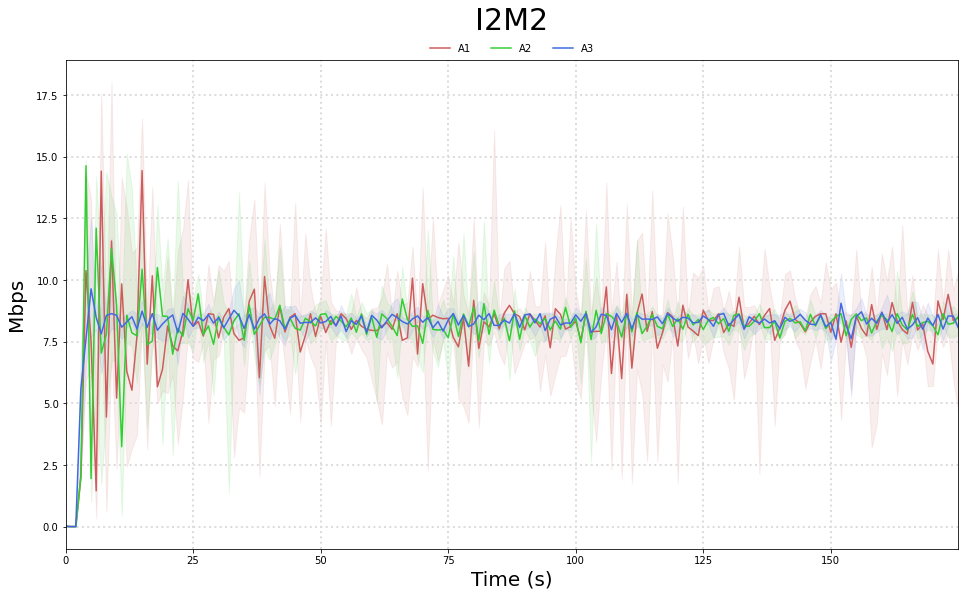

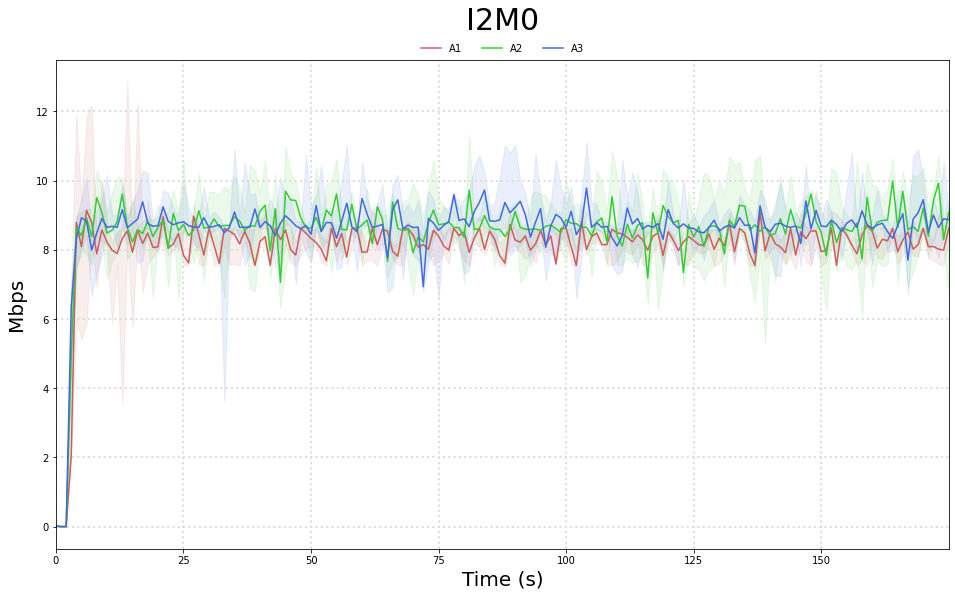

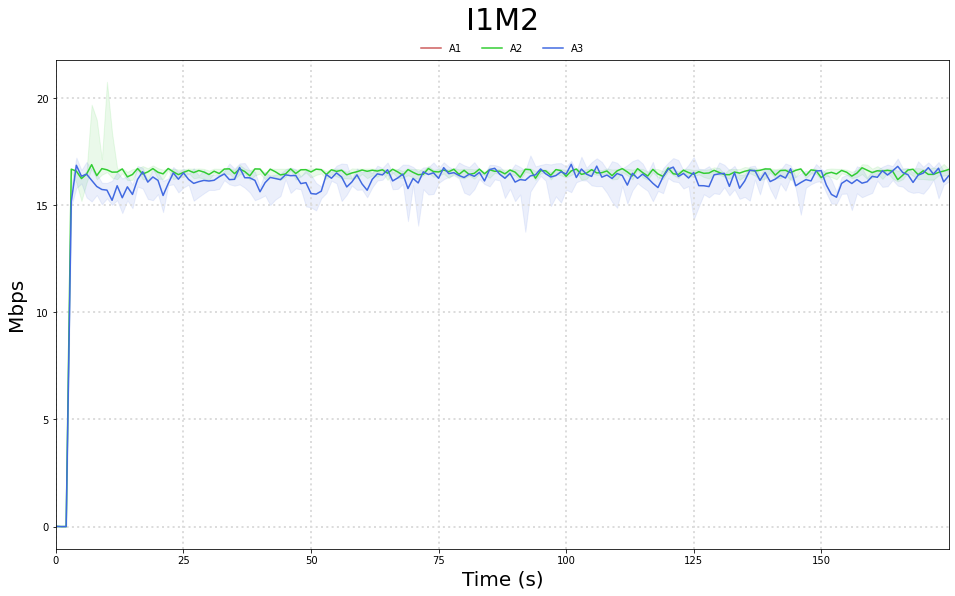

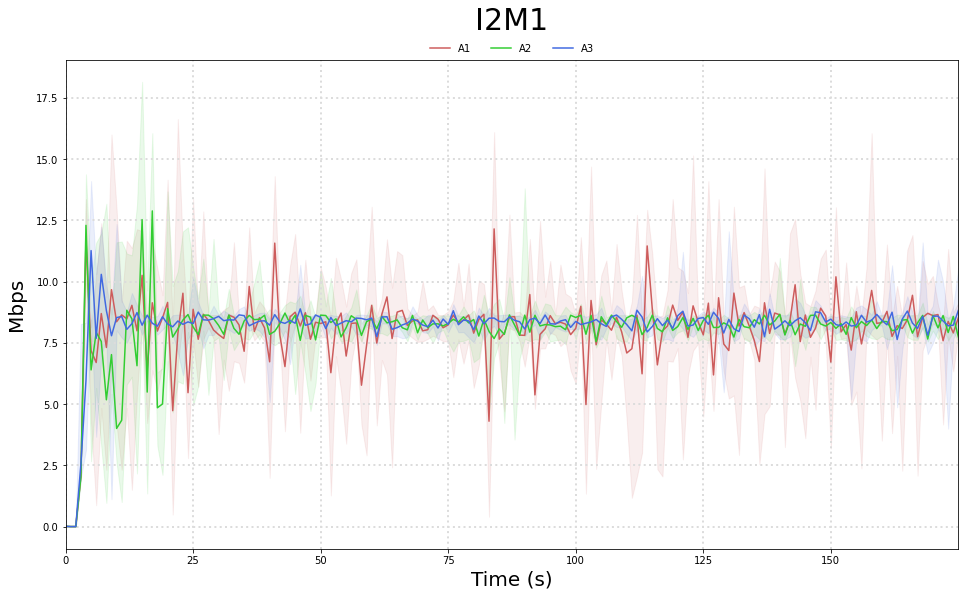

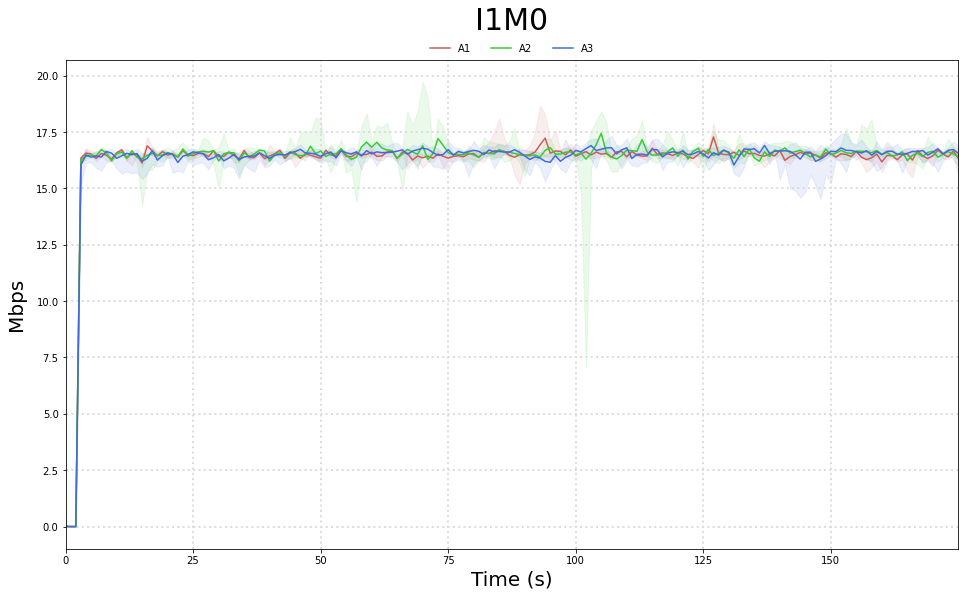

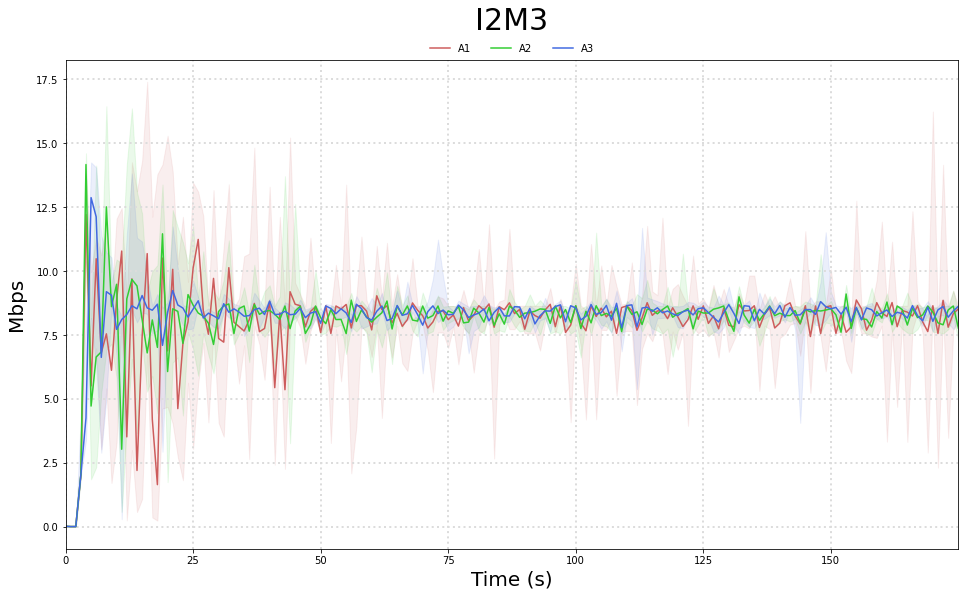

In [7]:
figs = experiments_suite.plot_experiments('Mbps')
for fig in figs:
    figs[fig].savefig(f'./graphs/{fig}_Mbps.pdf')

In [44]:
experiments_suite.get_factors_importance()

(8, 176, 10)
(8, 10)
(8,)
(8, 8)
(8,)
1.0000000000000024


,A,I,M,AI,AM,IM,AIM,Err
0,0.05,0.92,0.0,0.0,0.0,0.01,0.0,0.02
